In [ ]:
import pydra

# functions used later in the notebook:

@pydra.mark.task
def add_two(x):
    return x + 2

@pydra.mark.task
def power(a, n=2):
    return a**n

@pydra.mark.task
def mult_var(a, b):
    return a * b

## Introduction to Workflow

In order to run multiple tasks within one pipeline, we use another *pydra* class - `Workflow`. The workflow will contain arbitrary number of tasks that will be treated as a graph's nodes.

Let's start from a workflow with a single task that has one input `x`. When we create a `Workflow`, we have to specify `input_spec` that contains all of the workflow inputs:

In [ ]:
wf1 = pydra.Workflow(name="wf1", input_spec=["x"], x=3)

Now, we can add a task and specify that `x` will be taken from the workflow input by using so-called *Lazy Input*, `x=wf1.lzin.x`. We should also add the `name` to the task we are using in the `Workflow`.

In [ ]:
wf1.add(add_two(name="sum", x=wf1.lzin.x))

Now, we can access the task by using the task name:

In [ ]:
wf1.sum

We have to also specify what would be the workflow output, for this one-task workflow, we simply take the output of `sum` and we use *Lazy Output* to set it to `wf.output.out`:

In [ ]:
wf1.set_output([("out", wf1.sum.lzout.out)])

Now, we are ready to run the workflow:

In [ ]:
with pydra.Submitter(plugin="cf") as sub:
    sub(wf1)

wf1.result()

The result of the workflow should be the same as the output of the task, i.e. 5.

We could think about the workflow as follows: the workflow has an input `x` that is passed to the "sum" task, once the task has its input it runs as always and produces an output, the output is later set to the workflow output. 

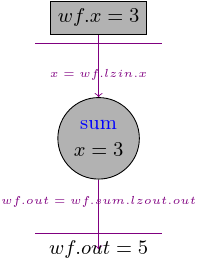

You can add as many task as you want to the workflow and return multiple variables:

In [ ]:
wf2 = pydra.Workflow(name="wf2", input_spec=["x"], x=3)
wf2.add(add_two(name="add_two", x=wf2.lzin.x))
wf2.add(power(name="power", a=wf2.lzin.x))

# setting multiple workflow output
wf2.set_output([("out_s", wf2.add_two.lzout.out),
                ("out_p", wf2.power.lzout.out)
               ])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf2)

wf2.result()

In this example we had two tasks, that took inputs from the workflow input and pass the outputs to the workflow output:

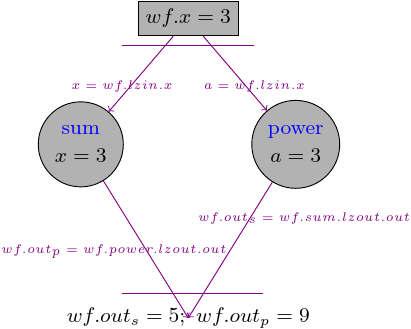

### Connecting tasks

The previous example showed a workflow with two nodes, but they were not connected with each other.

If we want to connect the tasks, we simply have to set the input of the second task to the output of the first task, and we use again the `Lazy Output` concept:

In [ ]:
wf3 = pydra.Workflow(name="wf3", input_spec=["x"], x=3)
wf3.add(add_two(name="sum", x=wf3.lzin.x))
# by setting a=wf3.sum.lzout.out we create a connection
wf3.add(power(name="power", a=wf3.sum.lzout.out))

wf3.set_output([("out_s", wf3.sum.lzout.out),
                ("out_p", wf3.power.lzout.out)
               ])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf3)

wf3.result()

Now, we could see that the second task took an input from the first one:

In [ ]:
wf3.power.inputs.a

So this time the workflow graph will look like this:

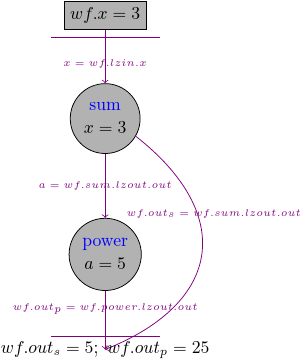

The node can be connected to multiple nodes, we can modify `wf` to add additional node that uses `mult_var` to multiple the outputs of two previous tasks:

In [ ]:
wf4 = pydra.Workflow(name="wf4", input_spec=["x"], x=3)
wf4.add(add_two(name="add_two", x=wf4.lzin.x))
wf4.add(power(name="power", a=wf4.lzin.x))
wf4.add(mult_var(name="mult", a=wf4.add_two.lzout.out, b=wf4.power.lzout.out))

wf4.set_output([("out", wf4.mult.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf4)

wf4.result()

This time the graph should look like this:

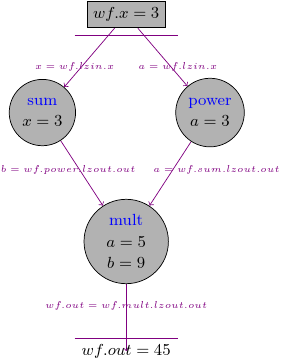

### Workflow as a node

Previously we had workflows that had `Task`s as nodes, but *pydra* treats `Workflow` as any other `Task`, so the workflow could be used as a node.

Let's modify the previous workflow, and instead of `sum` and `power` tasks we use `wf2` as the first node:

In [ ]:
wf2a = pydra.Workflow(name="wf2a", input_spec=["x"])
wf2a.add(add_two(name="add_two", x=wf2a.lzin.x))
wf2a.add(power(name="power", a=wf2a.lzin.x))

wf2a.set_output([("out_s", wf2a.add_two.lzout.out),
                ("out_p", wf2a.power.lzout.out)
               ])


wf5 = pydra.Workflow(name="wf5", input_spec=["x"], x=3)
wf5.add(wf2a)
# connecting wfa to the input from the main workflow
wf2a.inputs.x = wf5.lzin.x
wf5.add(mult_var(name="mult", a=wf5.wf2a.lzout.out_s, b=wf5.wf2a.lzout.out_p))

wf5.set_output([("out", wf5.mult.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf5)

wf5.result()

We should get exactly the same result as previously, but this time we run `wf2a` inside our main workflow:

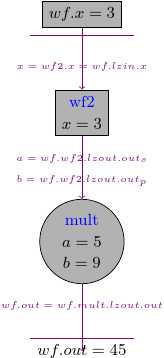

### Workflow with a splitter

Workflow as any other task could also have a splitter. Let's take one of our previous workflows and add a splitter for the workflow input by setting `splitter` using the `split` method.

In [ ]:
wf6 = pydra.Workflow(name="wf6", input_spec=["x"])
# setting a plitter for the entire workflow
wf6.split(splitter="x", x=[3, 5])
wf6.add(add_two(name="add_two", x=wf6.lzin.x))
wf6.add(power(name="power", a=wf6.lzin.x))
wf6.add(mult_var(name="mult", a=wf6.add_two.lzout.out, b=wf6.power.lzout.out))

wf6.set_output([("wf_out", wf6.mult.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf6)

wf6.result()

As we could expect, we received a list with two `Result`s, one is for `wf.x=3`, and the other is for `wf.x=5`. 

Behind the scene *pydra* expanded two workflows for two values of the workflow input:  

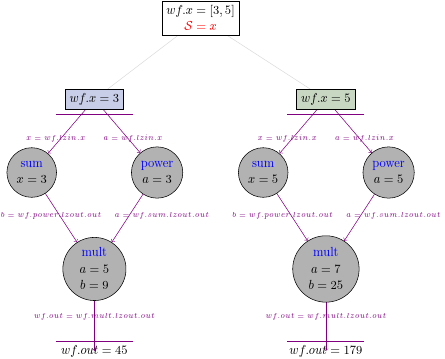

Let's create a new workflow that has two inputs and more complicated splitter.

In [ ]:
wf7 = pydra.Workflow(name="wf7", input_spec=["x", "y"])
wf7.split(splitter=["x", "y"], x=[3, 5], y=[2, 3])
wf7.add(add_two(name="sum", x=wf7.lzin.x))
wf7.add(power(name="power", a=wf7.lzin.y))
wf7.add(mult_var(name="mult", a=wf7.sum.lzout.out, b=wf7.power.lzout.out))

wf7.set_output([("out", wf7.mult.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf7)

wf7.result()

We should have four results for four sets of inputs, and the graph should look like this:

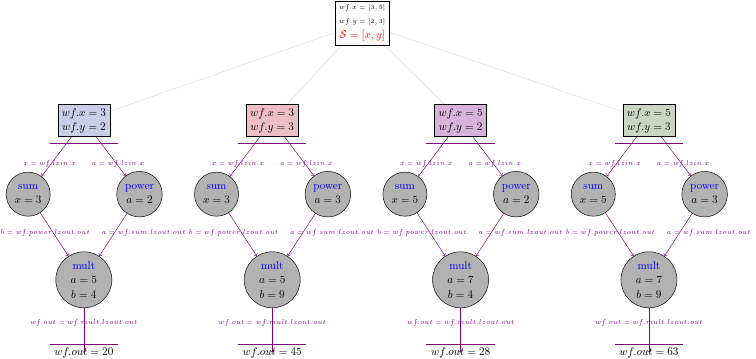

### Adding a combiner

In the same way as we did for `Task`, we can add a `combiner` to the entire workflow:

In [ ]:
wf7.combine(combiner="x")

with pydra.Submitter(plugin="cf") as sub:
    sub(wf7)

wf7.result()

Now we should have two lists in the results, one for `y=2` and one for `y=3`:

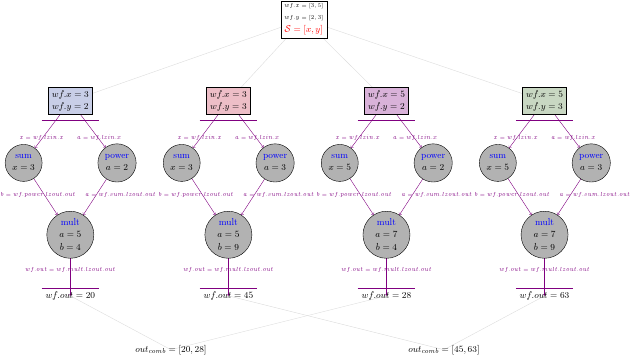

### Setting a splitter for nodes

We presented how to set a `splitter` and a `combiner` for entire workflow, but we could also set a `splitter` and a `combiner` on the level of a single node.

Let's create a workflow that takes a list as an input, and pass this input to two nodes. One node can take entire list as its input and the second node splits the input: 

In [ ]:
@pydra.mark.task
def mean(x_list):
    return sum(x_list)/len(x_list)

wf8 = pydra.Workflow(name="wf8", input_spec=["x"], x=[3, 5, 7])
wf8.add(mean(name="mean", x_list=wf8.lzin.x))
# adding a task that has its own splitter
wf8.add(power(name="power", a=wf8.lzin.x).split(splitter="a"))

wf8.set_output([("out_m", wf8.mean.lzout.out),
                ("out_p", wf8.power.lzout.out)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf8)

wf8.result()

This time we have in the workflow output a single value from the `mean` task and three values from the `power` task. The graph should look like this:

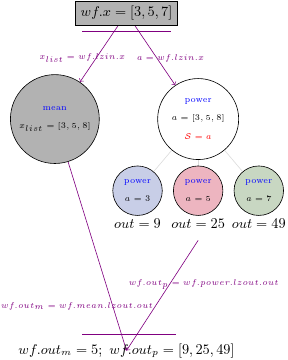